In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

# Lesions to use

We must define the bbox of the lesions to detect using the DBT model framework.

In [2]:
from utils import dataset_CDD_CESM, patient_CDD

In [3]:
mode = 'substracted'
dataset_CESM = dataset_CDD_CESM(mode=mode)
print(dataset_CESM)

# exclude cases with 'non mass' tags
meta_filterd = dataset_CESM.metadata[~dataset_CESM.metadata['Tags'].str.contains('non mass')]
# filter to keep only casses with word 'mass' in the tags
meta_filterd = meta_filterd[meta_filterd['Tags'].str.contains('mass')]
print(meta_filterd['Pathology Classification/ Follow up'].value_counts().to_string())
mass_patients = meta_filterd['Patient_ID'].unique()
print(f'Number of patients with mass: {len(mass_patients)}')
dataset_CESM.redefine_metadata(meta_filterd)

CDD-CESM dataset with 326 patients
Total images: 1003
Pathology Classification/ Follow up
Malignant    204
Benign        51
Number of patients with mass: 138


In [4]:
pat_id = dataset_CESM.patient_ids[1]
patient = patient_CDD(pat_id, dataset_CESM)
print(patient)


Patient 3 with 2 images


Image 1 of 2


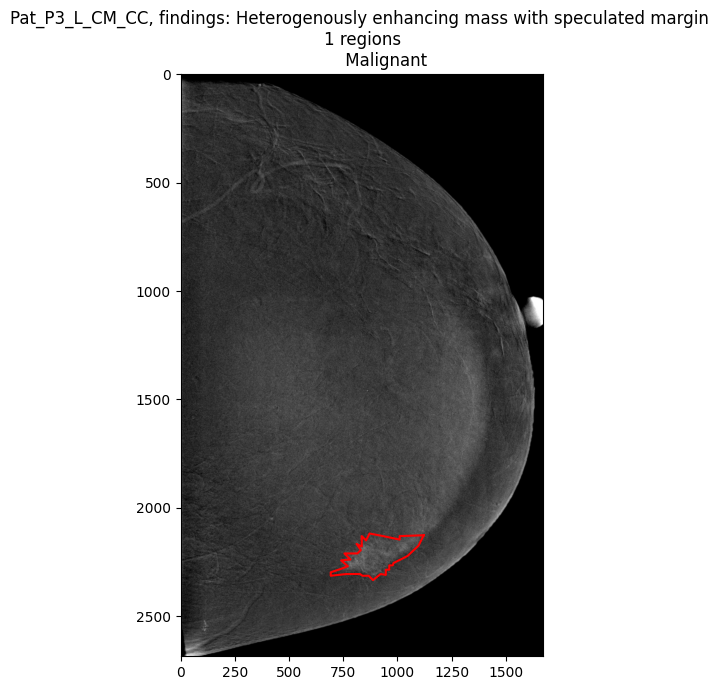

In [5]:
patient.set_image()
im_array = patient.get_array(plot=False)
patient.plot_annotations()

In [6]:
patient.metadata.Image_name[0]

'P3_L_CM_CC '